In [4]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np
import PIL
import PIL.Image
import os
import pickle
import pandas as pd
from skimage.color import rgb2gray
from skimage import filters
import random as r

In [5]:
X = {'image': [], 'ID': [], 'raw': []}
X_test = {'image': [], 'ID': [], 'raw': []}
h, w = 112, 112

# Augmentation



# Preprocesamiento

- Cargamos los datos de entrenamiento, los reescalamos para poder usarlos con mayor facilidad y los pasamos a escala de grises, ya que, pudimos apreciar que el modelo aprende mejor con las cartas que tienen fondo negro. Observamos que con los primeros epoch tendía a centrarse más en el color blanco, decidimos aplicar esta transformación puesto que el fondo es la parte menos determinante de la carta.


Tambien separamos los datos en train y test.

In [6]:
def preproces_img(path, df, h=h, w=w):
    img = cv2.imread(path)
    img = cv2.resize(img, (h, w))
    img = rgb2gray(img)
    img = np.expand_dims(img, 0)
    img = img / 255
    df['raw'].append(img)
    df['image'].append(filters.scharr(img))

def load_data(path, df):
    list_ = os.listdir(path)
    for mem in list_:
        df['ID'].append(mem)
        imagePath = path + '/' + mem
        preproces_img(imagePath, df)



train_path = './Data/train'
test_path = './Data/test'

# Train
load_data(train_path, X)
# Test
load_data(test_path, X_test)


Mostramos las imagenes.

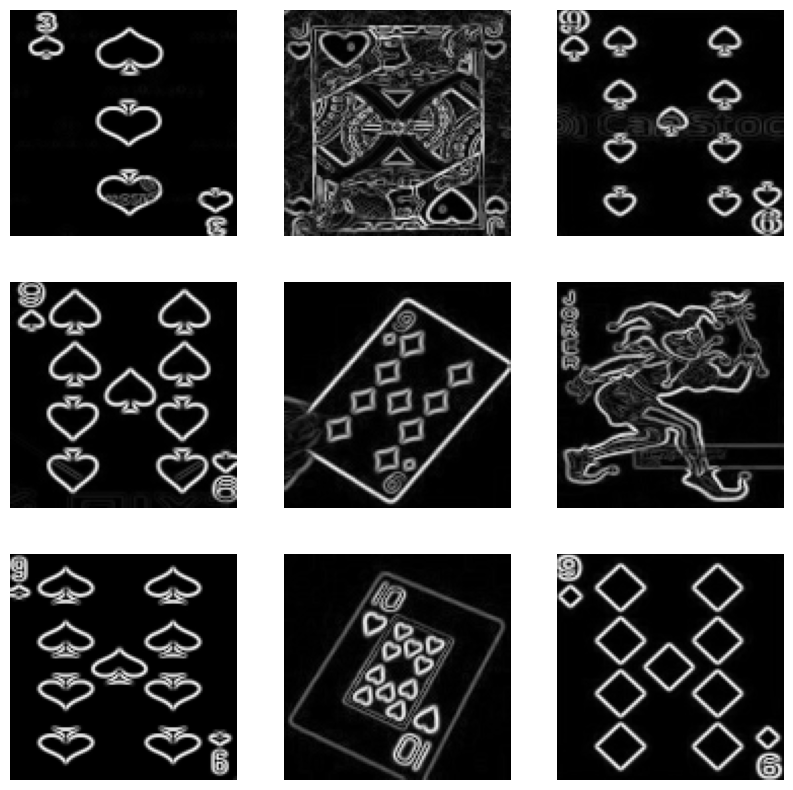

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  idx = r.randint(0, len(X['image']) -1)
  plt.imshow(X['image'][idx].reshape(h, w, 1), cmap='gray')
  plt.axis("off")


In [8]:
def create_autoencoder():
    input = tf.keras.layers.Input(shape=(h, w, 1))

    # Encoder
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)

    encoder = tf.keras.Model(input, x, name='encoder')

    # Decoder
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    # Autoencoder
    autoencoder = tf.keras.Model(input, x, name='autoencoder')
    autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
    return autoencoder, encoder

autoencoder, encoder = create_autoencoder()
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 56, 56, 64)       

"Aplanamos" las imágenes para poder usarlas 

In [9]:
x_train = np.array(X['image']).reshape(-1, h, w, 1)
x_test = np.array(X_test['image']).reshape(-1, h, w, 1)

x_train.shape, x_test.shape

((7889, 112, 112, 1), (265, 112, 112, 1))

In [10]:
checkpoint_path = "training/autoencoder-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32
epochStep = 5

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True
  )
autoencoder.save_weights(checkpoint_path.format(epoch=0))

In [12]:
autoencoder, encoder = create_autoencoder()

latest = tf.train.latest_checkpoint(checkpoint_dir)

autoencoder.load_weights(latest)

# Re-evaluate the model
# loss, acc = autoencoder.evaluate(x_test, x_test, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

def train_autoencoder(epochs=45):
  history = autoencoder.fit(
    x_train,
    x_train,
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[cp_callback],
    validation_split=0.1
  )   
  autoencoder.save_weights(f"models/AE-{epochs}.h5")

train_autoencoder()

Epoch 1/45
222/222 [==============================] - ETA: 0s - loss: 0.0595
Epoch 1: val_loss improved from inf to 0.00234, saving model to training\autoencoder-0001.ckpt
222/222 [==============================] - 126s 568ms/step - loss: 0.0595 - val_loss: 0.0023
Epoch 2/45
222/222 [==============================] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.00234 to 0.00232, saving model to training\autoencoder-0002.ckpt
222/222 [==============================] - 115s 517ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/45
222/222 [==============================] - ETA: 0s - loss: 0.0023
Epoch 3: val_loss improved from 0.00232 to 0.00232, saving model to training\autoencoder-0003.ckpt
222/222 [==============================] - 72s 324ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/45
222/222 [==============================] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss improved from 0.00232 to 0.00231, saving model to training\autoencoder-0004.ckpt
222/222 [=============

# Predicción

In [13]:
ae_out = autoencoder.predict([ np.array(X_test['image']).reshape(-1, h, w, 1) ])

9/9 [==============================] - 1s 74ms/step


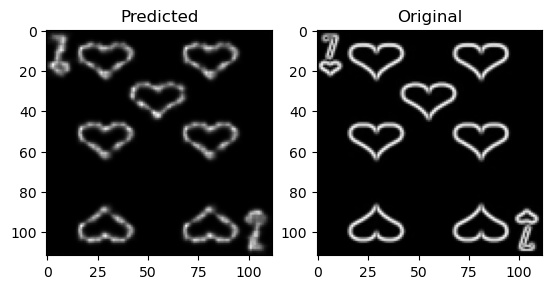

In [18]:
idx = r.randint(0, len(ae_out) -1)
plt.subplot(121)
plt.imshow(ae_out[idx], cmap='gray')
plt.title('Predicted')
plt.subplot(122)
plt.imshow(x_test[idx], cmap='gray')
plt.title('Original')
plt.show()

# Visualición Clusters

Utilizamos AgglomerativeClustering para dividir toda la población (predicha) en clusters y visualizar los resultados.

In [49]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import Isomap

isomap = Isomap(n_neighbors=50, n_components=2)

X = encoder.predict(x_train)
X = isomap.fit_transform(X.reshape(X.shape[0], -1))


clu = AgglomerativeClustering(n_clusters=5)
y = clu.fit_predict(X)

247/247 [==============================] - 7s 28ms/step


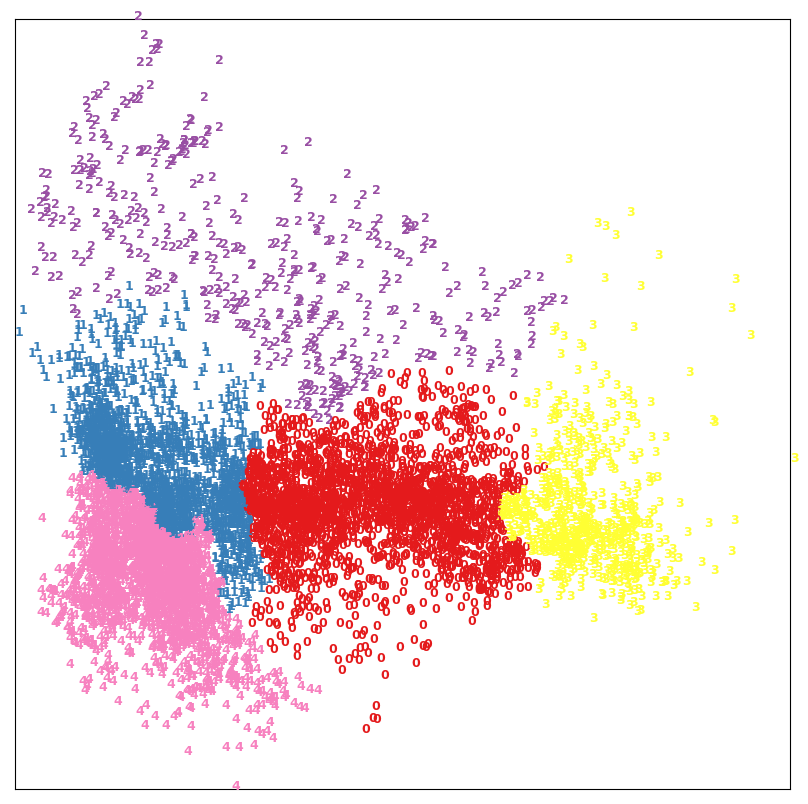

In [50]:
def plot_isomap(X, y):    
    # normalizacion de los datos
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # definicion de los datos
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                color=plt.cm.Set1(y[i] / 5.),
                fontdict={'weight': 'bold', 'size': 9})

    # desactivacion de las marcas de los ejes
    plt.xticks([]), plt.yticks([])
    plt.show()

plot_isomap(X, y)

In [51]:
pred = pd.DataFrame({'id': [], 'suit': []})
pred['id'] = X_test['ID']
pred['id'] = pred['id'].str.replace('.jpg', '', regex=True)

X = encoder.predict(x_test)
X = isomap.transform(X.reshape(X.shape[0], -1))

y = clu.fit_predict(X)

pred['suit'] = y

pred.to_csv('./Data/prediction.csv', index=False)

pred

9/9 [==============================] - 0s 26ms/step


,id,suit
0,106,2
1,1120,0
2,1127,0
3,1154,2
4,1181,0
...,...,...
260,866,0
261,905,1
262,91,0
263,946,3


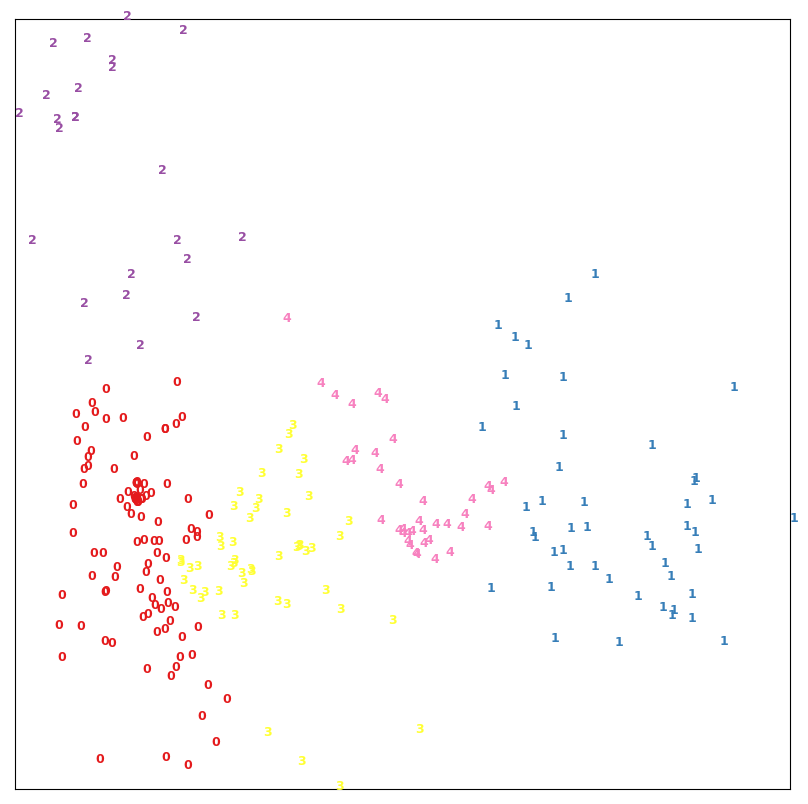

In [52]:
plot_isomap(X, y)